In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets import widgets
from scipy.io import loadmat # to read .mat file
from ipywidgets import interact
from scipy.misc import imread, imshow
%matplotlib inline

In [2]:
def rel_error(x, expected_x, verbose=True):
    if verbose:
        print(np.sum(np.square(x - expected_x)))
    else:
        return np.sum(np.square(x-expected_x))

# K-Means 알고리즘

Pseudocode for kMeans
```matlab
% Initialize centroids
centroids = kMeansInitCentroids(X, K);
for iter = 1:iterations
    % Cluster assignment step: Assign each data point to the
    % closest centroid. idx(i) corresponds to cˆ(i), the index
    % of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids);
    % Move centroid step: Compute means based on centroid
    % assignments
    centroids = computeMeans(X, idx, K);
end
```

## findClosetCentroids를 정의

하는 일:

1. centroids = np.array (K, D) - 각 K 클러스터의 중심점
2. X와 각각의 centroids 중 가장 가까운 클러스터를 idx[i] 에 저장

In [3]:
def findClosetCentroids(X, centroids):
    """
    calculate each centroid distance from each sample and return closet one's index
    
    X (np.array) : (m, d)
    centroids (np.array) : (K, d)
    
    Returns
    ==========
    idx : (m, 1) # each sample belong to one cluster
    """
    m, d = X.shape    
    dist = X.reshape(m, 1, d) - centroids #(10, 3, 5)
    dist_sq = np.sum(np.square(dist), 2)  #(10, 3)
    idx = np.argmin(dist_sq, axis=1)      #(10, 1) 0~K
    
    return idx

## Test Data 확인

In [4]:
K = 3
init_centroids = np.array([[3,3], [6,2], [8,5]])
test = loadmat("data/ex7data2.mat")['X']

In [5]:
idx = findClosetCentroids(test, init_centroids)
rel_error(idx[0:3], np.array([0, 2, 1])) # should return 0, 2, 1

0


# computeCentroids(=computeMeans)를 정의
현재 각 클러스터들의 평균을 재계산함

In [6]:
def computeCentroids(X, idx, K):
    """
    Parameters
    ==============
    X : (m, d)
    idx : (m, 1) # which indicates each sample belongs to idx[i] cluster
    ==============
    returns centroids (np.array) : (K, d) # centroid for each cluster
    """
    m, d = X.shape
    centroids = np.zeros(shape=(K, d))
    for i in range(K):
        target = X[idx==i]
        centroids[i] = np.mean(target, axis=0)
    
    return centroids

In [7]:
centroids = computeCentroids(test, idx, K)

expected_result = np.array([
    [ 2.428301, 3.157924 ],
    [ 5.813503, 2.633656 ],
    [ 7.119387, 3.616684 ],
])

rel_error(centroids, expected_result)
#nnp.allclose(centroids, expected_result)

5.18193476548e-13


# kMeans Runner 정의

In [8]:
class KMeans(object):
    
    def __init__(self, max_iters = 10, K = 3):
        self.max_iters = max_iters
        self.K = K
        self.centroids = None
        self.centroids_history = []
        self.idx_history = []
        
    def init_centroids(self, X):
        m, d = X.shape
        choices = np.random.choice(range(m), replace=False, size=self.K)
        self.centroids_history.append(X[choices, :])
        return X[choices, :]
    
    def fit(self, X):
        m, d = X.shape
        self.centroids = self.init_centroids(X)
        # print(self.centroids)
        
        for i in range(self.max_iters):
            idx = findClosetCentroids(X, self.centroids)            
            self.centroids = computeCentroids(X, idx, self.K)
            self.centroids_history.append(self.centroids)
            self.idx_history.append(idx)

In [9]:
K = 3
max_iters = 10
kmeans = KMeans(max_iters, K)
kmeans.fit(test)

def animate(i):
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.scatter(test[:, 0], test[:, 1], c = kmeans.idx_history[i], alpha = 0.1)
    centroids = kmeans.centroids_history[i]
    axes.scatter(centroids[:, 0], centroids[:, 1], c = range(K), marker='^', s=100)    
    plt.show()

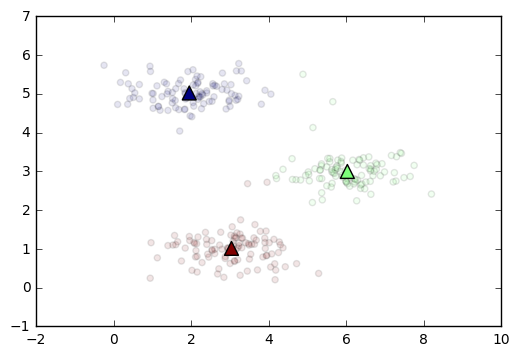

<function __main__.animate>

In [10]:
interact(animate, i=(0, max_iters - 1, 1))

# Image compression with K-means

In [11]:
def draw_img(img, title, fig_no=111):
    plt.subplot(fig_no)
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    #plt.show()

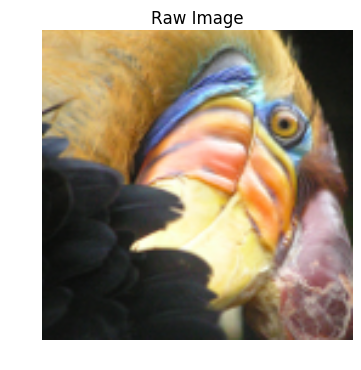

In [12]:
bird_img = imread("./data/bird_small.png")
bird_img = bird_img / 255.0 # so that its range from 0 to 1
draw_img(bird_img, "Raw Image")

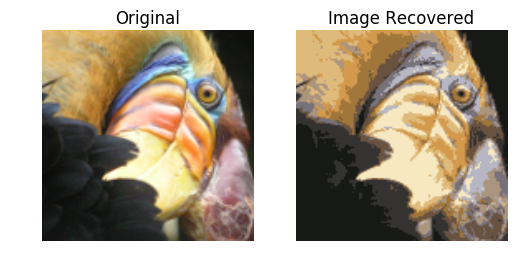

In [13]:
test2 = bird_img.reshape(-1, 3) #change to (128*128, 3)
K_ = 10 # to 10 bits 
max_iters_ = 100
kmeans2 = KMeans(max_iters_, K_)

kmeans2.fit(test2)

final_clusters = kmeans2.idx_history[-1]
final_centroids = kmeans2.centroids_history[-1]

test_recovered = final_centroids[final_clusters, :]

test_recovered = test_recovered.reshape(*bird_img.shape)

draw_img(bird_img, "Original", 121)
draw_img(test_recovered, "Image Recovered", 122)

# PCA

Before using PCA, it is necessary to do mean-normalization and feature scaling.

Two parts of calculating PCA

1. Calculate co-variance Matrix of the data
2. U, S, V = svd (Covariance Matrix) where Covariance Matrix = $\Sigma$ 


If we want to reduce the dimensionality to K then calculate $$U_{reduced} = \begin{bmatrix}
                                                       | &| &\dots &| \\
                                                       u_0 &u_1 &\dots &u_K\\
                                                       | &| &\dots &|
                                                    \end{bmatrix}$$
                                                    

Then, we can get $$X_{projected} = X \cdot U_{reduced}^T$$  


In [14]:
pca_test1 = loadmat("./data/ex7data1.mat")['X']

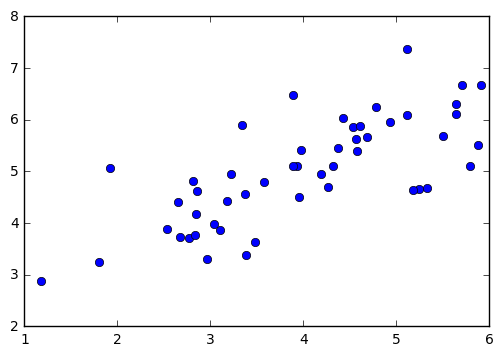

In [15]:
plt.plot(pca_test1[:, 0], pca_test1[:, 1], 'o')
plt.show()

# First Define FeatureNormalize

$$ X_{normalized} = \frac{X-\mu}{\sigma} $$

In [16]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    return (X-mu)/sigma, mu, sigma

def PCA(X):
    m, d = X.shape
    SIGMA = (1/m) * X.T.dot(X)
    return np.linalg.svd(SIGMA)
    
def projectData(X, U, K):
    reducedU = U[:, :K]
    return X.dot(reducedU)

def recoverData(Z, U, K):
    reducedU = U[:, :K]
    return Z.dot(reducedU.T)

In [17]:
test_norm, test_MU, test_SIGMA = featureNormalize(pca_test1)

In [18]:
U, S, V = PCA(test_norm)

In [19]:
Z = projectData(test_norm, U, 1)
rel_error(Z[0, 0], 1.481274)

0.000226159744349


In [20]:
test_norm_recovered = recoverData(Z, U, 1)
rel_error(test_norm_recovered[0, 0], -1.047419)
rel_error(test_norm_recovered[0, 1], -1.047419)

0.000113077536882
0.000113077536882


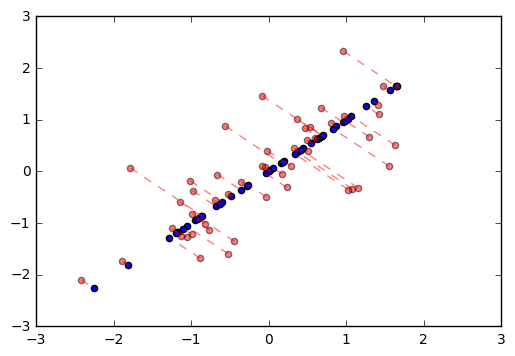

In [21]:
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(test_norm_recovered[:, 0], test_norm_recovered[:, 1])
plt.scatter(test_norm[:, 0], test_norm[:, 1], c='r', alpha=0.5)
for i in range(test_norm.shape[0]):
    tmp = np.append(test_norm[i:i+1, :], test_norm_recovered[i:i+1, :], axis=0)
    plt.plot(tmp[:, 0], tmp[:, 1], 'r--', alpha=0.5)

# Face Data

In [22]:
face_raw = loadmat("./data/ex7faces.mat")['X']

In [23]:
def draw_N_images(X, N):
    m, d = X.shape
    img_size = int(np.sqrt(d))
    for i in range(N):
        plt.subplot(2, N//2, i+1)        
        plt.imshow(X[i, :].reshape(img_size, img_size).T, cmap='gray')
        plt.axis('off')

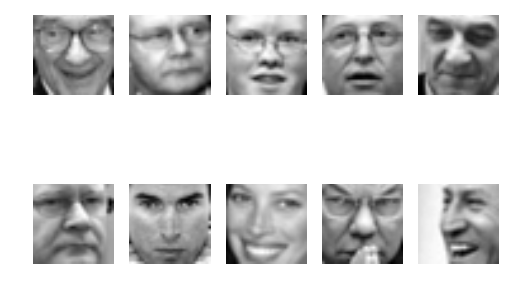

In [24]:
draw_N_images(face_raw, 10)

In [25]:
face_norm, face_mu, _ = featureNormalize(face_raw)
U, S, V = PCA(face_norm)

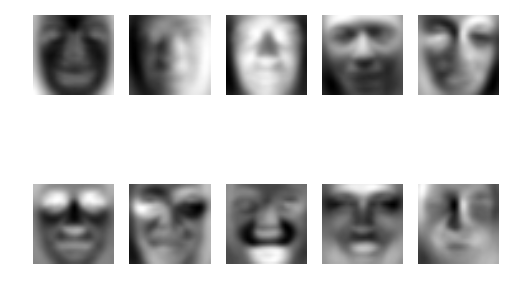

In [30]:
draw_N_images(U[:, :36].T, 10) # Eigenvectors Top 36

In [27]:
K = 100
Z = projectData(face_norm, U, K)
print(Z.shape)

(5000, 100)


In [28]:
X_rec = recoverData(Z, U, K)
print(X_rec.shape)

(5000, 1024)


Original


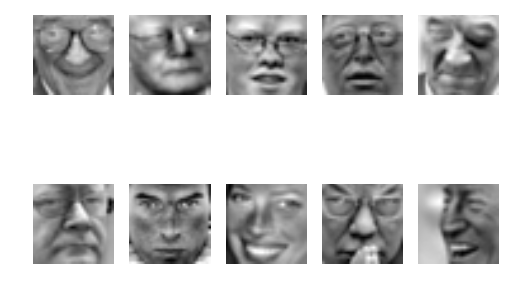

Recovered from PCA


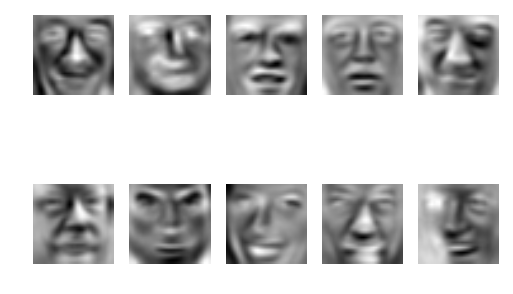

In [29]:
print("Original")
draw_N_images(face_norm, 10)
plt.show()
print("Recovered from PCA")
draw_N_images(X_rec, 10)
plt.show()